<h1> Info </h1>

<p>This script analyzes SFG data from Igor files. </p>

---

<p>Using Anaconda, the following external packages must be installed:</p>
<p style="margin-left: 40px">- lmfit</p>
<p style="margin-left: 40px">- igor</p>
<p style="margin-left: 40px">- xarray</p>
<p style="margin-left: 40px">- sif_reader</p>
<p>To install standard external packages open a terminal (Anaconda Prompt in Windows or another terminal if using Linux/Mac) and type:</p>

<p style="margin-left: 40px">pip install [Package Name]</p>

<p> sif_reader is not a standard package must be downloaded manually from <a href=https://github.com/fujiisoup/sif_reader>GitHub</a>.</p>
<p>To run in Jypyter Lab, <a href="https://nodejs.org">NodeJS</a> must be installed. After installing NodeJS, run the following command in a terminal:</p>
<p></p>
<p style="margin-left: 40px">jupyter labextension install @jupyter-widgets/jupyterlab-manager</p>

---

Created by Jerry LaRue, larue@chapman.edu, 12/2018

Last modified by Jerry LaRue, larue@chapman.edu, 06/2020

# SFG data fitting background

<p>The intensity of the SFG signal, $I_{SFG}$ is proportional to the second order susceptibility, $\chi^{(2)}$:</p>
<p>$$I_{SFG}(\hbar\omega)\propto\lvert\chi^{(2)}\rvert^{2}\hspace{1cm}(1)$$</p>
<table>
  <col width="15">
  <col width="180">
  <tr>
    <td>$\chi^{(2)}$</td>
    <td style="text-align:left">Second order susceptibility</td>
  </tr>
</table> 
<p>The second order susceptibility has a non-resonant, $\chi_{NR}^{(2)}$, and a resonant, $\chi_{R}^{(2)}$, component:</p>
<p>$$\chi^{(2)}=\chi_{NR}^{(2)}+\chi_{R}^{(2)}\hspace{1cm}(2)$$</p>
<p>The non-resonant component is given by:</p>
<p>$$\chi_{NR}^{(2)} = A_{0}\hspace{1cm}(3)$$</p>
<p> The resonant component is given by:</p>
<p>$$\chi_{R}^{(2)}=\frac{Ae^{i\phi}}{\hbar\omega_{IR}-\hbar\omega_{0}+i\Gamma}\hspace{1cm}(4)$$</p>
<table>
  <col width="15">
  <col width="150">
  <tr>
    <td>$A$</td>
    <td style="text-align:left">Amplitude</td>
  </tr>
  <tr>
    <td>$\omega_{0}$</td>
    <td style="text-align:left">Resonant frequency</td>
  </tr>
  <tr>
    <td>$\Gamma$</td>
    <td style="text-align:left">Linewidth</td>
  </tr>
</table> 
<p>The intensity of the SFG signal is then proportional to:</p>
<p>$$I_{SFG}(\hbar\omega)\propto\lvert\chi_{NR}^{(2)}+\chi_{R}^{(2)}\rvert^{2}\hspace{1cm}(5)$$</p>
<p>$$=\chi_{NR}^{(2),2}+\chi_{R}^{(2),2}+\chi_{NR}^{(2)}\chi_{R}^{(2)}\hspace{1cm}(6)$$</p>
<p>$$=A_{0}^{2}+\frac{A^{2}e^{i2\phi}}{(\hbar\omega_{IR}-\hbar\omega_{0}+i\Gamma)^{2}}+\frac{AA_{0}e^{i\phi}}{\hbar\omega_{IR}-\hbar\omega_{0}+i\Gamma}\hspace{1cm}(7)$$</p>
<p>To calculate the SFG signal, the intensity of the IR and VIS pulses, $I_{sum}$, must be taken into account:</p>
<p>$$I_{SFG}(\hbar\omega)=\lvert\chi_{NR}^{(2)}+\chi_{R}^{(2)}\rvert^{2} I_{sum}\hspace{1cm}(8)$$</p>
<p>$I_{sum}$ is taken from the non-resonant background of the SFG data.</p>
<p>The above code is for a single resonant peak. This can be readily expanded to multiple resonant peaks through the expansion of $\chi_{R}^{(2)}$.</p>
<p>To fit data, array w of length 4 * Number of Peaks + 1 will be created to store multipeak fitting parameters to equation (7):</p>
<p>$$I_{SFG}(\hbar\omega)\propto A_{0}^{2}+\frac{A^{2}e^{i2\phi}}{(\hbar\omega_{IR}-\hbar\omega_{0}+i\Gamma)^{2}}+\frac{AA_{0}e^{i\phi}}{\hbar\omega_{IR}-\hbar\omega_{0}+i\Gamma}\hspace{1cm}(7)$$</p>
<table>
  <col width="15">
  <col width="250">
  <tr>
    <td>w[0]</td>
    <td style="text-align:left">Amplitude for Non-Resonant Peak, $A_{0}$</td>
  </tr>
  <tr>
    <td>w[1+3n]</td>
    <td style="text-align:left">Amplitude for Resonant Peak n+1, $A_{n+1}$</td>
  </tr>
  <tr>
    <td>w[2+3n]</td>
    <td style="text-align:left">Phase for Resonant Peak n+1, $\phi_{n+1}$</td>
  </tr>
  <tr>
    <td>w[2+3n]</td>
    <td style="text-align:left">Frequency for Resonant Peak n+1, $\omega_{0,n+1}$</td>
  </tr>
  <tr>
    <td>w[2+3n]</td>
    <td style="text-align:left">Width for Resonant Peak n, $\Gamma_{n+1}$</td>
  </tr>
</table> 

# Select Data

In [1]:
import numpy as np
import igor.igorpy as igor
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Button, Layout
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import lmfit
from lmfit import model, Model
import lmfit.models as models
import math, cmath
from pandas import DataFrame as df
from igor import binarywave
import string
import re
import csv
import SFGTools
from importlib import reload

reload(SFGTools)
dt = SFGTools.DataTools()

##### Widgets #####

ParameterFile = widgets.Dropdown(
    options=dt.FileList(os.getcwd(),['.yaml']),
    description='Select File',
    layout=Layout(width='70%'),
    style = {'description_width': '150px'},
    disabled=False,
)

display(ParameterFile)

Dropdown(description='Select File', layout=Layout(width='70%'), options=('SFG181009_01 - Methanol+O-Ni - 2600-…

# Data fitting

HTML(value='<div align="center">Methanol decomposition on O/Ni(111)</div>', placeholder='')

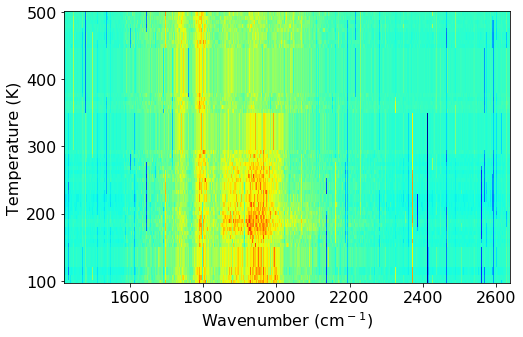

Button(description='Fit Data', style=ButtonStyle())

Output()

In [3]:
 %matplotlib inline

##### Button Functions #####

def FitData_Clicked(b):
    
    with out:
        clear_output(True)
        sfg.ReloadData()
        sfg.GetBackground()
        sfg.FitData()
        
        ParametersToClipboard = widgets.Button(description="Copy parameters")
        ParametersToClipboard.on_click(ParametersToClipboard_Clicked)
        display(ParametersToClipboard)

def ParametersToClipboard_Clicked(b):
    ToCopy = sfg.FitParameters
    ToCopy.to_clipboard()

##### Load Data #####

sfg = SFGTools.SFG(ParameterFile.value)

Description = widgets.HTML(
    value= '<div align="center">' + sfg.Parameters['Description'] + '</div>',
    placeholder='',
    description='',
)

display(Description)

##### Plot Data #####

Data = sfg.Data

x = Data.index.values
y = Data.columns.values
z = np.transpose(Data.values)

fig = plt.figure(figsize=(8,5))
plt.xlabel('Wavenumber (cm$^-$$^1$)', fontsize=16)
plt.ylabel('Temperature (K)', fontsize=16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
pcm = plt.pcolor(x, y, z, cmap='jet')
plt.show()

##### UI Controls #####

Background_Type = widgets.RadioButtons(
    options=['Data','Fit'],
    value='Fit',
    description='Type',
    layout=Layout(width='20%'),
    style = {'description_width': '100px'},
    disabled=False
)

FitData = widgets.Button(description="Fit Data")
FitData.on_click(FitData_Clicked)

display(FitData)

out = widgets.Output()
out

# Plot trends

In [ ]:
 %matplotlib inline

FitParameters = sfg.FitParameters

def Unique_Parameters(l):
    upar = []
    [upar.append(x.split('_')[1]) for x in l if x.split('_')[1] not in upar]
    return upar

def UpdateTrends(b) :
    clear_output(True)
    with out :
        clear_output(True)
        Select = list()
        for x in FitParameters.columns :
            if ('_'+Select_Parameter.value) in x :
                Select.append(x)
        plt.figure(figsize=(10,6))
        plt.xlabel('Temperature (K)')
        plt.ylabel('Fit values (AU)')
        plt.plot(FitParameters[Select],'.-',linewidth=2)
        plt.legend(FitParameters[Select].columns)
        plt.show()

Parameters = Unique_Parameters(FitParameters.columns)
Select_Parameter = widgets.Dropdown(
    options=Parameters,
    style = {'width': '100px','description_width': '150px'},
    description='Select Parameter:',
    disabled=False,
)

button_UpdateTrends = widgets.Button(description="Show Trends")
button_UpdateTrends.on_click(UpdateTrends)

ParametersToClipboard = widgets.Button(description="Copy parameters")
ParametersToClipboard.on_click(ParametersToClipboard_Clicked)

display(widgets.Box([Select_Parameter, button_UpdateTrends, ParametersToClipboard]))
display()
out = widgets.Output()
out

# Plot data & fits

In [ ]:
%matplotlib inline

Data = sfg.FitData
Fits = sfg.Fits
FitParameters = sfg.FitParameters
Temperature = FitParameters.index

def UpdatePlot(b) :
    with out :
        clear_output(True)
        plt.figure(figsize=(10,6))
        plt.xlabel('WaveNumber ($cm^{-1}$)')
        plt.ylabel('Signal (AU)')
        for i in Select_T.index :
            x = sfg.FitData.index.values
            y = Data[Select_T.options[i]].values
            plt.plot(x,y,'.',label=str(Select_T.options[i])+' K - Data', linewidth=2)
            if ShowFits.value :
                x = sfg.Fits.index.values
                y = Fits[Select_T.options[i]]
                plt.plot(x,y, '-',label=str(Select_T.options[i])+' K - Fit', linewidth=2)
        if ShowLegend.value :
            plt.legend()
        plt.show()

if len(FitParameters) < 20 :
    NumberRows = len(FitParameters)
else :
    NumberRows = 20

Select_T = widgets.SelectMultiple(
    options=Temperature,
    style = {'width': '100px','description_width': '150px'},
    rows=NumberRows,
    layout=Layout(width='30%'),
    description='Temperatures (K)',
    disabled=False
)

button_UpdatePlot = widgets.Button(description="Update")
button_UpdatePlot.on_click(UpdatePlot)

ShowFits = widgets.Checkbox(
    value=True,
    description='Show Fits?',
    layout=Layout(width='18%'),
    disabled=False
)

ShowLegend = widgets.Checkbox(
    value=True,
    description='Legend?',
    layout=Layout(width='18%'),
    disabled=False
)

display(widgets.Box([Select_T, button_UpdatePlot,ShowFits,ShowLegend]))
out = widgets.Output()
out